<a href="https://colab.research.google.com/github/reza-dalvand/Skin_Cancer/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)
!cp -r /kaggle/input/skin-cancer-mnist-ham10000 /content/dataset


Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
!mkdir /content/dataset/HAM10000_images_combined/
!mv /content/dataset/HAM10000_images_part_1/* /content/dataset/HAM10000_images_combined/
!mv /content/dataset/HAM10000_images_part_2/* /content/dataset/HAM10000_images_combined/
# !rm -rf /content/dataset/

In [ ]:
image_dir = '/content/dataset/HAM10000_images_combined'
df = pd.read_csv('/content/dataset/HAM10000_metadata.csv')
df['image_id'] = df['image_id'] + '.jpg'  # Match actual file names

datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,              # 30% reserved for val + test
    stratify=df['dx'],
    random_state=42
)

# Second split: val + test from temp_df
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,              # 50% of 30% = 15% test
    stratify=temp_df['dx'],
    random_state=42
)



train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_id',
    y_col='dx',
    target_size=(28, 28),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_id',
    y_col='dx',
    target_size=(28, 28),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='image_id',
    y_col=None,               # No labels
    target_size=(28, 28),
    class_mode=None,          # Important: no labels
    batch_size=32,
    shuffle=False             # Important: keep order for matching predictions
)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames.


In [ ]:

model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3),
activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,327 (1.74 MB)

 Trainable params: 456,327 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=25,
    batch_size=32,
    validation_data=val_gen,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 57s 233ms/step - accuracy: 0.6592 - loss: 1.1271 - val_accuracy: 0.6698 - val_loss: 1.0245
Epoch 2/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 220ms/step - accuracy: 0.6680 - loss: 0.9579 - val_accuracy: 0.6798 - val_loss: 0.9320
Epoch 3/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 219ms/step - accuracy: 0.6728 - loss: 0.9138 - val_accuracy: 0.6711 - val_loss: 0.9039
Epoch 4/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.6816 - loss: 0.8945 - val_accuracy: 0.6951 - val_loss: 0.8493
Epoch 5/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 208ms/step - accuracy: 0.6864 - loss: 0.8371 - val_accuracy: 0.6944 - val_loss: 0.8399
Epoch 6/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 209ms/step - accuracy: 0.6809 - loss: 0.8357 - val_accuracy: 0.7091 - val_loss: 0.8088
Epoch 7/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 209ms/step - accuracy: 0.6963 - loss: 0.8266 - val_accuracy: 0.7037 - val_loss: 0.7937
Epoch 8/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 208ms/step - accuracy: 0.6889 - loss: 0

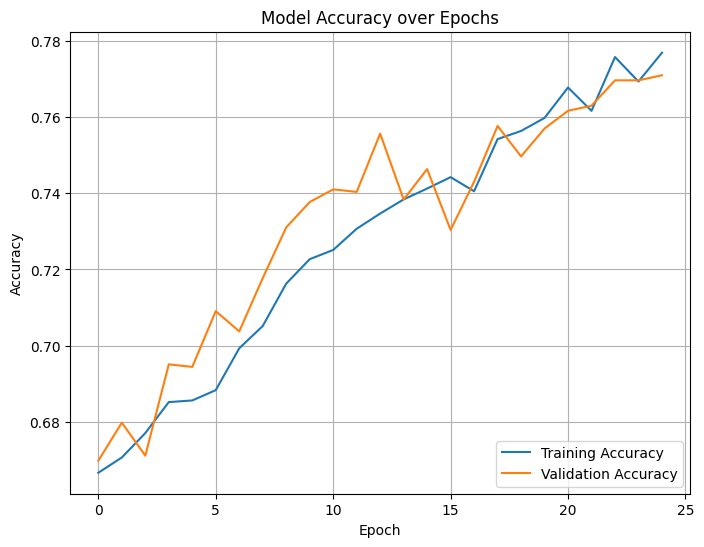

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)

class_indices = train_gen.class_indices
print(class_indices)
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_labels = [inv_class_indices[i] for i in predicted_classes]
print(predicted_labels)
